In [4]:
###### CS170 HEADER
"""
Chris Buonocore
904587506
Outlier detection for overvalued and undervalued stocks (done relatively).
"""

%matplotlib inline
import numpy as np
import scipy as sp
import matplotlib as mp
import matplotlib.pyplot as plt
import scipy.linalg.interpolative as sli
import matplotlib.cm as cm
import seaborn as sns
import pandas as pd
import numpy.linalg as LA
import math
import os
import gc

from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn import linear_model
from sklearn import preprocessing
from sklearn import svm

from sklearn.model_selection import train_test_split
from scipy import stats
from scipy.interpolate import griddata
from scipy import interpolate

from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression, LogisticRegression, SGDRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import Imputer
from sklearn import linear_model

from sklearn.model_selection import cross_val_score
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn import svm
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.feature_selection import SelectKBest

from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline

from sklearn.feature_extraction import DictVectorizer


np.set_printoptions(precision=2) #2 decimal places
np.set_printoptions(suppress=True) #remove scientific notation

from datetime import date
from pprint import pprint
from yahoo_finance import Share

"""
module_name, package_name, ClassName, method_name, 
ExceptionName, function_name, GLOBAL_CONSTANT_NAME, 
global_var_name, instance_var_name, function_parameter_name, 
local_var_name
"""

# motley_data_file = './stockdata_2017-01-06.csv' #'./stockdata.csv'
print('done')

done


In [143]:
purchase_dir = './sourcingboston/data/redtomato/purchases'
sales_dir = './sourcingboston/data/redtomato/sales'

UNIT_CONV = {
    "BG": "Bag",
    "BN": "Bin",
    "CS": "Case",
    "EA": "Each",
    "LB": "Pound",
    "RL": "RL",
    "TH": "TH",
}

def is_csv(f):
    return 'csv'in f

def pfile(f):
    return os.path.join(purchase_dir, f)

def sfile(f):
    return os.path.join(sales_dir, f)

def is_eco(apple):
    return apple[-1] == 'E'

def is_organic(apple):
    return apple[-1] == 'O'

sales_files = list(filter(is_csv, os.listdir(sales_dir)))
purchase_files = list(filter(is_csv, os.listdir(purchase_dir)))


print('sales', sales_files)
print('purchases', purchase_files)

sales ['Sales Data 2014-2018.csv', 'Sales History 2018.csv', 'Sales History 2015.csv', 'Sales History 2014.csv', 'Sales History 2016.csv', 'Sales History 2017.csv']
purchases ['Pur_History_2018.csv', 'Pur_History_2016.csv', 'Pur_History_2017.csv', 'Pur_History_2015.csv', 'Pur_History_2014.csv', 'Pur_History_2014-2018.csv']


In [ ]:
class RT:
    
    
    def __init__(self):
        return
    
    def 

In [38]:
# price paid to growers
pdata = pd.read_csv(pfile('Pur_History_2014-2018.csv'))



In [40]:
pdata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22631 entries, 0 to 22630
Data columns (total 20 columns):
Itemcode                     22631 non-null object
Item Description             22631 non-null object
Brand                        22631 non-null object
Pack-size                    22631 non-null object
Vendor ID                    22631 non-null object
Receive Date                 22631 non-null object
PO Number                    22631 non-null int64
PO Line #                    22631 non-null int64
Ordered Quantity             22631 non-null int64
Order UOM                    22631 non-null object
Received Quantity            22631 non-null int64
Rec. UOM                     22631 non-null object
Weight (LB)                  22631 non-null float64
Variance (Quantity)          22631 non-null float64
Estimate Inventory Cost      22631 non-null float64
Actual Inventory Cost        22631 non-null float64
Variance (Inventory Cost)    22631 non-null float64
Estimate Add-on Cost   

In [44]:
pdata = pdata.applymap(lambda x: x.strip() if type(x)==str else x)

In [136]:
pdata = pdata[(pdata['Rec. UOM'] == 'CS') & (pdata['Received Quantity'] != 0)]
pdata = pdata[pdata['Item Description'].str.contains('McIntosh')]

In [137]:
pdata['price'] = pdata['Actual Inventory Cost']/pdata['Received Quantity']

In [138]:
pdata.to_csv('mcintosh.csv')

In [142]:
pdata['year'] = pdata['Receive Date'].map(lambda x: x.split('/')[-1])


In [145]:
data_year = pdata.groupby('year')

In [147]:
# data_year[:]

In [76]:
set(pdata['Rec. UOM'])

{'CS'}

In [77]:
pdata.groupby(['Itemcode',).plot()

SyntaxError: invalid syntax (<ipython-input-77-67827e742576>, line 1)

In [78]:
app_14 = pdata[pdata['Itemcode'] == 'APP14']

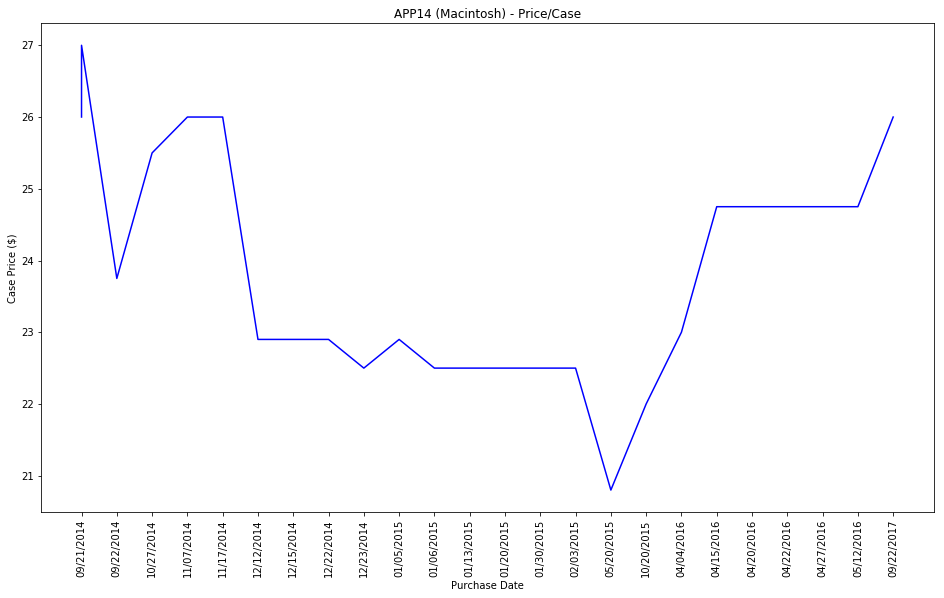

In [79]:
plt.figure(figsize=(16,9))
x = app_14['Receive Date']
y = app_14['price']
plt.plot_date(x, y, 'b-')
plt.xticks(rotation=90)
plt.title('APP14 (Macintosh) - Price/Case')
plt.xlabel('Purchase Date')
plt.ylabel('Case Price ($)')
plt
plt.show()

In [118]:
# pdata.groupby(['Itemcode']).count().sort()

g = pdata.groupby(['Itemcode']).agg({'price': np.mean})

In [125]:
# res = g.apply(lambda x: x.order(ascending=False).head(3))
# g.nlargest(3)
g.sort_values(by=['price'], ascending=False)[:10]

,price
Itemcode,
MSC1,321.250000
TANLB,211.260000
POLY1,156.250000
RAMO2,150.000000
NET1,125.000000
ASP6,72.200000
ASP4,64.285714
NET2,62.500000
APPE40,57.891026


In [134]:
g = pdata.groupby(['Itemcode'])['price']

KeyError: 'Received Date'